# Preliminaries

In [1]:
from dissipationtheory.constants import ureg, qe, epsilon0
from dissipationtheory.dissipation9a import CantileverModel, SampleModel3
from dissipationtheory.dissipation9b import SampleModel3Jit
from dissipationtheory.dissipation13e import twodimCobject as twodimCobjectPrior
from dissipationtheory.dissipation14e import get_device, Cmatrix, rpIII 
from dissipationtheory.dissipation14e import twodimCobject, comparetwoK

In [2]:
import torch
import numpy as np
import matplotlib.pylab as plt

In [3]:
from numba import jit

In [4]:
from lmfit import Model, Parameters

In [5]:
THIS = 'dissipation-theory--Study-70--'
figs = {}
t = {}

# Calculate BLDS $\Delta f_{\mathrm{ac}}$ spectra on the GPU

Get the GPU device.

In [6]:
device = get_device(verbose=True)

Using MPS (Apple Silicon GPU)


An array of frequencies and heights.

In [7]:
omega_m__numpy = np.logspace(start=3,stop=6,num=40)
dh__numpy = np.linspace(0, 50, 6) 

Check out the array of heights.

In [8]:
dh__numpy

array([ 0., 10., 20., 30., 40., 50.])

Rewrite the `rp_III_integrator` to accept another vector argument `dh` (or $\Delta h$). \
Use this vector to translate the image-charge and test-point vectors, to increase the tip-sample separation.

In [9]:
@torch.compile
def rp_III_integrator(
    omega: float,
    omega0: float,
    kD: float,
    es: complex,
    sj: torch.tensor,
    rk: torch.tensor,
    dh: float,  # new
    pts: int,
    device: torch.device,
) -> torch.tensor:

    y_min = 2.0e-9
    y_max = 2.0e1

    w = torch.linspace(
        torch.log(torch.tensor(y_min)),
        torch.log(torch.tensor(y_max)),
        pts,
        device=device,
    )

    sj = sj + dh # new
    rk = rk + dh # new
    
    zjkref = sj[2] + rk[2]
    x = torch.sqrt((sj[0] - rk[0]) ** 2 + (sj[1] - rk[1]) ** 2) / zjkref

    t0 = torch.exp(w)
    t1 = torch.exp(w - t0)
    t2 = torch.special.bessel_j0(t0 * x)
    t3 = rpIII(t0, omega, omega0, zjkref, kD, es)

    I0 = t1 * t2 * t3
    I1 = t0 * I0
    I2 = t0 * I1

    K0 = torch.trapezoid(y=I0, x=w) / zjkref**1
    K1 = torch.trapezoid(y=I1, x=w) / zjkref**2
    K2 = torch.trapezoid(y=I2, x=w) / zjkref**3

    return [K0, K1, K2]  # Works if this is a list but NOT a torch.tensor()

Create a mapping of `rp_III_integrator` onto height changes $\Delta h$ *and* frequencyes $\omega$ and well as onto the $s_j$ and $r_k$ vectors.

In [10]:
KmatrixIIIhw = \
torch.vmap(
    torch.vmap(
        torch.vmap(
            torch.vmap(
                rp_III_integrator,
                in_dims=(None, None, None, None, None, 0, None, None, None),
                out_dims=0,
            ),
            in_dims=(None, None, None, None, 0, None, None, None, None),
            out_dims=0,
        ),
        in_dims=(0, None, None, None, None, None, None, None, None),
        out_dims=0,
    ),
    in_dims=(None, None, None, None, None, None, 0, None, None),
    out_dims=0
)
    

In [11]:
class twodimCobjectExperimental(twodimCobject):

    def solve(self, dh_list, omega_list):
        """Solve for the charges.  The parameter $\alpha$ is used to filter
        the singular values in the inverse.  The parameter omega is the unitless
        cantilever frequency in rad/s.       
        """
        
        sj = torch.as_tensor(self.sj.astype(np.float32), device=self.device)
        rk = torch.as_tensor(self.rk.astype(np.float32), device=self.device)
        
        Ctensor = Cmatrix(sj, rk) # doesn't depend on tip-sample separation or frequency
        
        if self.sample.type == 3:
            
            omega0 = self.sample.omega0.to('Hz').magnitude
            kD = self.sample.kD.to('1/m').magnitude
            es = self.sample.epsilon_s.to('').magnitude
            
            K0tensor, K1tensor, K2tensor = KmatrixIIIhw(omega_list, omega0, kD, es, sj, rk, dh_list, self.pts, self.device)
            
        else:
            
            raise Exception("unknown sample type")
                
        C = Ctensor.cpu().numpy()
        K0 = K0tensor.cpu().numpy() 
        K1 = K1tensor.cpu().numpy()
        K2 = K2tensor.cpu().numpy()
        
        return C, K0, K1, K2

Create *tensor* arrays for the BLDS frequencies and the height changes.

In [12]:
omega_m__torch = torch.as_tensor(omega_m__numpy.astype(np.float32), device=device)
dh__torch = torch.as_tensor(dh__numpy.astype(np.float32), device=device)

In [13]:
(dh__torch.shape, omega_m__torch.shape)

(torch.Size([6]), torch.Size([40]))

A representative cantilever and Type III sample.

In [56]:
cantilever = CantileverModel(
    f_c=ureg.Quantity(62, "kHz"),
    k_c=ureg.Quantity(2.8, "N/m"),
    V_ts=ureg.Quantity(1, "V"),
    R=ureg.Quantity(60, "nm"),
    angle=ureg.Quantity(20, "degree"),
    L=ureg.Quantity(1000, "nm"),
)

sample3 = SampleModel3(
    cantilever=cantilever,
    epsilon_s=ureg.Quantity(complex(3, 0), ""),
    sigma=ureg.Quantity(1e-6, "S/m"),
    rho=ureg.Quantity(1e21, "1/m^3"),
    z_r=ureg.Quantity(1, "nm"),
)

sample3_jit = SampleModel3Jit(**sample3.args())

The starting tip-sample separation. \
We'll need this number later.

In [15]:
h0 = 100

Set up the cantilever and solve for the $C$ matrix and the $K_n$ matrices.

In [16]:
obj1 = twodimCobjectExperimental(sample3, device)
obj1.addsphere(ureg.Quantity(h0,'nm'), 21, 24)
obj1.set_alpha(1.0e-6)
obj1.set_integration_points(21 * 15)
C, K0, K1, K2 = obj1.solve(dh__torch, omega_m__torch)

Check that the returned matrices have the expected shape.

In [17]:
(C.shape, K0.shape)

((24, 21), (6, 40, 24, 21))

In [18]:
%timeit obj1.solve(dh__torch, omega_m__torch)

141 ms ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


The execution time should be compared to 24.5 ms for computing the spectrum at one height (Study 69). \
We would estimate 6 $\times$ 24.5 = 147 ms, and we see about 143 ms.  \
Surprisingly, there is little speedup from the extra `vmap` step. \
We have, however, eliminated a loop in the code.

Now compute the $(\Lambda_0, \Lambda_1, \Lambda_2)$ vectors. \
Add a second loop to the code in Study 69.

In [19]:
m, n, M, N = K0.shape
(m, n, M, N)

(6, 40, 24, 21)

In [20]:
def reduce(C, K0, K1, K2, alpha, cGinv, cG):
    
    m, n, M, N = K0.shape
    
    L0 = np.zeros((m,n), dtype=np.complex64)
    L1 = np.zeros((m,n), dtype=np.complex64)
    L2 = np.zeros((m,n), dtype=np.complex64)
    Q = np.zeros((m,n,N), dtype=np.complex64)    
    Vrms = np.zeros((m,n), dtype=np.float32)
    Vones = np.ones(M, dtype=np.float32)
 
    G0 = C - K0
    
    for index1 in np.arange(m):
        
        for index2 in np.arange(n):

            U, S, VT = np.linalg.svd(G0[index1,index2,:,:], full_matrices=False)

            filt = np.diag(np.power(S, 2)/(np.power(S, 2) + alpha**2))
            Sinv = filt * np.diag(np.power(S, -1))
            G0inv = VT.T @ Sinv @ U.T

            IdN = np.ones(N).T
            IdM = np.ones(M)

            L0[index1,index2] = IdN @ G0inv @ IdM
            L1[index1,index2] = -2 * IdN @ G0inv @ K1[index1,index2,:,:] @ G0inv @ IdM
            L2[index1,index2] = 4 * IdN @ (G0inv @ K2[index1,index2,::] @ G0inv 
                                + 2 * G0inv @ K1[index1,index2,:,:] @ G0inv @ K1[index1,index2,:,:] @ G0inv) @ IdM     

            Q[index1,index2] = cGinv * complex(0,1) * G0inv @ IdM
            V = -1 * complex(0,1) * cG * G0[index1,index2,:,:] @ Q[index1,index2]

            Vrms[index1,index2] = np.std(V - Vones)
        
    return L0, L1, L2, Vrms, Q

In [21]:
L0, L1, L2, Vrms, Q = reduce(C, K0, K1, K2, obj1.alpha, obj1.cGinv, obj1.cG)

In [22]:
(L0.shape, Vrms.shape, Q.shape)

((6, 40), (6, 40), (6, 40, 21))

In [23]:
%timeit reduce(C, K0, K1, K2, obj1.alpha, obj1.cGinv, obj1.cG)

22.8 ms ± 62.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


We would expect 6 $\times$ 4 ms = 24 ms, which is about what we are seeing.  

A CPU function to obtain the frequency shift. \
Simply modify the code below to pass `df__torch` to the `solve` function.

In [24]:
def compute_blds_ac(obj, dh__torch, omega_m__torch):
    
    Cp, K0p, K1p, K2p = obj.solve(dh__torch,      omega_m__torch)
    Cm, K0m, K1m, K2m = obj.solve(dh__torch, -1 * omega_m__torch)
    
    L0p, L1p, L2p, _, _ = reduce(Cp, K0p, K1p, K2p, obj.alpha, obj.cGinv, obj.cG)
    L0m, L1m, L2m, _, _ = reduce(Cm, K0m, K1m, K2m, obj.alpha, obj.cGinv, obj.cG)
    
    V0 = obj.sample.cantilever.V_ts.to('V')
    fc = obj.sample.cantilever.f_c.to('Hz')
    kc = obj.sample.cantilever.k_c.to('N/m')
    
    c1 = 0.5 * np.pi * epsilon0 * V0**2
    Fac = c1 * np.imag(complex(0,1) * (L1p + L1m))     
    
    c2 = - 0.25 * (fc * np.pi * epsilon0 * V0**2) / (kc * obj.zr)
    dfac = c2 * (np.imag(complex(0,1) * (L2p + L2m)))
    
    return Fac.to('pN').magnitude, dfac.to('Hz').magnitude

We get an array of frequencies of the expected shape.

In [33]:
_, dfac1 = compute_blds_ac(obj1, dh__torch, omega_m__torch)

In [34]:
dfac.shape

(6, 40)

The execution time is about 0.33 s.

In [62]:
%timeit compute_blds_ac(obj1, dh__torch, omega_m__torch)

332 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Create an array of heights, $h = h_0 + \Delta h$

In [35]:
h = h0 + dh__numpy

In [36]:
def plotme(h, omega, df):
    
    fig, axs = plt.subplots(
        ncols=len(h),
        nrows=1,
        sharey=True,
        sharex=True,
        gridspec_kw={'wspace': 0},
        figsize=(2.0 * len(h), 3.0)) 

    axs[0].set_ylabel('frequency shift $|\Delta f_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [Hz]')
    for index, h_ in enumerate(h):
        
        axs[index].semilogx(omega, np.abs(df[index,:]), '-')
        axs[index].set_xlabel('$\omega_{\mathrm{m}}$ [Hz]')
        axs[index].set_title('$h = ${:0.0f} nm'.format(h_))
    
    return fig

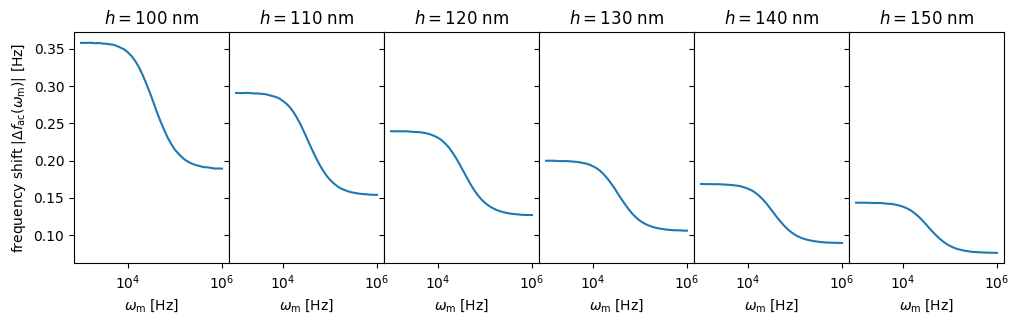

In [59]:
_ = plotme(h, omega_m__numpy, dfac1)

# Calculate BLDS $\Delta f_{\mathrm{ac}}$ and $\Delta f_{\mathrm{am}}$ spectra on the CPU

In [38]:
from dissipationtheory.dissipation13e import twodimCobject as twodimCobjectPrior

Compute both shifts at once.

In [139]:
def properties_ac_spectrum(h, omega_m):
    
    dfac = np.zeros((len(h),len(omega_m)))
    dfam = np.zeros((len(h),len(omega_m)))
    
    for index1, h_ in enumerate(h):
        for index2, omega_ in enumerate(omega_m):
            
            obj = twodimCobjectPrior(sample3_jit)
            obj.addsphere(ureg.Quantity(h_,'nm'), 21, 24)
            obj.set_alpha(1.0e-6)
            obj.set_breakpoints(15)
            
            obj.properties_ac(omega_)
            dfac[index1,index2] = obj.results['Delta f ac [Hz]']
            
            obj.properties_am(omega_, 250.)
            dfam[index1,index2] = obj.results['Delta f am [Hz]']
            
    return dfac, dfam  

In [140]:
dfac2, dfam2 = properties_ac_spectrum(h, omega_m__numpy)

For computing jsut the AC spectrum, the execution time is 7.3 s on the CPU versus 0.33 s on the GPU, factor of 22 speedup.

The CPU $\Delta f_{\mathrm{ac}}$ results look similar to the GPU results computed above.

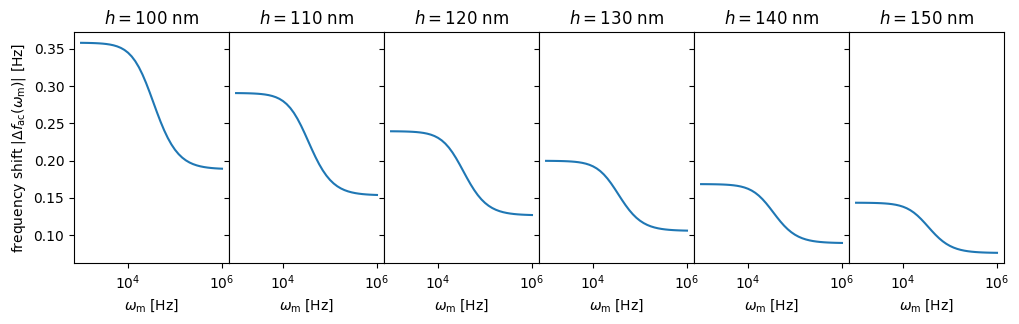

In [141]:
_ = plotme(h, omega_m__numpy, dfac2)

The $\Delta f_{\mathrm{am}}$ shift looks qualitatively similar, just smaller.

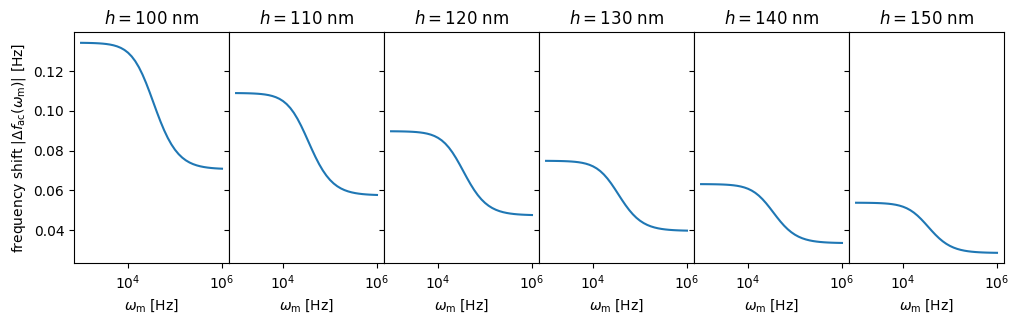

In [143]:
_ = plotme(h, omega_m__numpy, dfam2)

# Compare GPU and CPU $\Delta f_{\mathrm{ac}}$

In [112]:
def compareme(h, omega, df1, df2):

    args = {'markerfacecolor': 'white', 
        'markeredgecolor': 'black', 
        'markersize': 3, 
        'color': 'black'}    
    
    fig, axs = plt.subplots(
        ncols=len(h),
        nrows=2,
        sharey='row',
        sharex='col',
        gridspec_kw={'hspace':0, 'height_ratios': [1, 3]},
        figsize=(2.0 * len(h), 4.5)) 

    axs[0,0].set_ylabel(r'$r_{\mathrm{norm}} \times 10^{3}$')
    axs[1,0].set_ylabel('frequency shift $|\Delta f_{\mathrm{ac}} (\omega_{\mathrm{m}})|$ [Hz]')
    for index, h_ in enumerate(h):

        y1 = np.abs(df1[index,:])
        y2 = np.abs(df2[index,:])
        dy = 1e3 * (y1 - y2)/y1 
        
        axs[0,index].set_title('$h = ${:0.0f} nm'.format(h_))
        axs[0,index].semilogx(omega, dy, 'o', **args)  
        
        axs[1,index].semilogx(omega, y1, 'k-')
        axs[1,index].semilogx(omega, y2, 'o', **args)
        axs[1,index].set_xlabel('$\omega_{\mathrm{m}}$ [Hz]')
        
        axs[1,index].yaxis.set_major_locator(plt.MaxNLocator(4))
        
    fig.subplots_adjust(hspace=0)
    fig.align_ylabels()
    fig.tight_layout()    
    
    return fig

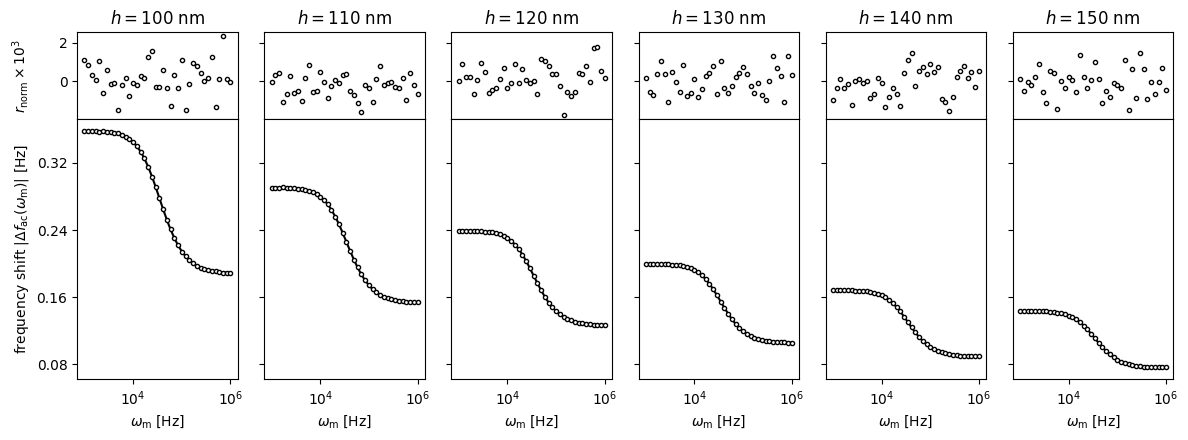

In [114]:
figs['01'] = compareme(h, omega_m__numpy, dfac2, dfac1)

Ok, this is the same reasonable agreement seen in Study 69.

# Calculate BLDS $\Delta f_{\mathrm{am}}$ spectra on the GPU

This is new code.

In [128]:
omega_am__torch = torch.as_tensor(250.0, device=device)

In [145]:
def compute_blds_am(obj, dh__torch, omega_m__torch, omega_am__torch):

    # Lambda values at six frequencies: 
    #
    #   +/- omega_m
    #   +/- (omega_m + omega_am)
    #   +/- (omega_m - omega_am)
    
    C = {}
    K0, K1, K2 = {}, {}, {}
    L0, L1, L2 = {}, {}, {}
    
    omega_list__torch = [ omega_m__torch,
                         -omega_m__torch,
                          omega_m__torch + omega_am__torch,
                         -omega_m__torch - omega_am__torch,
                          omega_m__torch - omega_am__torch,
                         -omega_m__torch + omega_am__torch]
    
    keys = ['a', 'b', 'c', 'd', 'e', 'f']
    
    for (key, omega) in zip(keys, omega_list__torch):
        
        C[key], K0[key], K1[key], K2[key] = obj.solve(dh__torch, omega)
        L0[key], L1[key], L2[key], _, _ = reduce(C[key], K0[key], K1[key], K2[key], obj.alpha, obj.cGinv, obj.cG)
    
    V0 = obj.sample.cantilever.V_ts.to('V')
    fc = obj.sample.cantilever.f_c.to('Hz')
    kc = obj.sample.cantilever.k_c.to('N/m')
    
    c1 = 2 * np.pi * epsilon0 * V0**2
    Fam = c1 * np.imag(complex(0,1) * (L1['a']/16 + L1['b']/16 + L1['c']/64 + L1['d']/64 + L1['e']/64 + L1['f']/64)) 

    c2 = - (fc * np.pi * epsilon0 * V0**2) / (kc * obj.zr)
    dfam= c2 * (np.imag(complex(0,1) * (L2['a']/16 + L2['b']/16 + L2['c']/64 + L2['d']/64 + L2['e']/64 + L2['f']/64)))
    
    return Fam.to('pN').magnitude, dfam.to('Hz').magnitude

In [146]:
_, dfam1 = compute_blds_am(obj1, dh__torch, omega_m__torch, omega_am__torch)

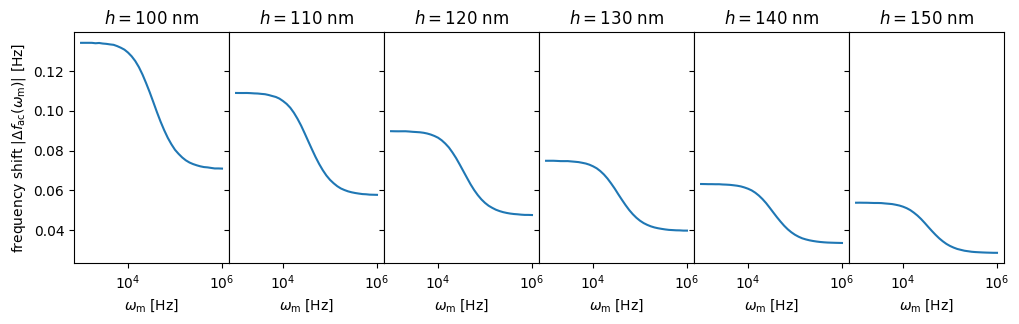

In [147]:
_ = plotme(h, omega_m__numpy, dfam1)

We see the same trends with frequeny and height, but the frequency shift is smaller in the am-modulation case.

Check the timing.

In [150]:
%timeit compute_blds_am(obj1, dh__torch, omega_m__torch, omega_am__torch)

990 ms ± 4.69 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Ok, about 1 s for six spectra. \
We expect curve fitting to take maybe 300 function evaluations. \
300 s is 5 min, which is a little painful but still acceptable.

# Compare GPU and CPU $\Delta f_{\mathrm{am}}$

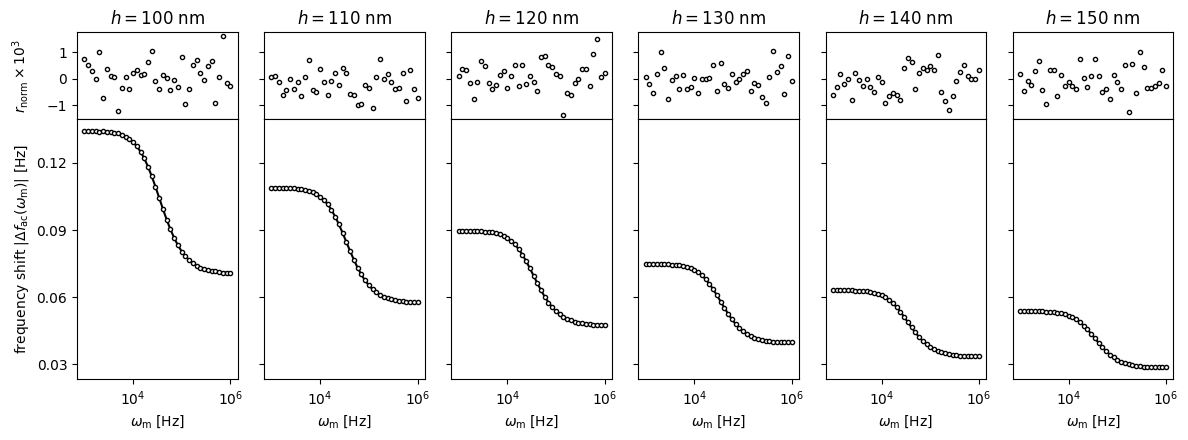

In [148]:
figs['02'] = compareme(h, omega_m__numpy, dfam2, dfam1)

Interestingly, the CPU versus GPU agreement is slightly better for $\Delta f_{\mathrm{am}}$ than for $\Delta f_{\mathrm{ac}}$.

# Curve fitting multiple spectra

Develop code to fit multiple spectra simultaneously. \
Use this code, as an example, to fit `dfam1` (the model) to `dfam2` (the data) and recover the sample parameters. \
[Here](https://millenia.cars.aps.anl.gov/software/python/lmfit/examples/example_fit_multi_datasets.html) is one example of `lmfit` fitting multuple datasets at once.

Use the fact the the arrays `dh__torch`, `omega_m__torch`, and `omega_am__torch` already exist. \
Here the `x` array, the dependent variable, is extraneous. \
I am just including it because that is what `lmfit` expects. 

In [186]:
def fitfunc_trial(x, epsilon, sigma, rho):
    
    cantilever = CantileverModel(
        f_c=ureg.Quantity(62, "kHz"),
        k_c=ureg.Quantity(2.8, "N/m"),
        V_ts=ureg.Quantity(1, "V"),
        R=ureg.Quantity(60, "nm"),
        angle=ureg.Quantity(20, "degree"),
        L=ureg.Quantity(1000, "nm"),
    )

    sample3 = SampleModel3(
        cantilever=cantilever,
        epsilon_s=ureg.Quantity(complex(epsilon, 0), ""),
        sigma=ureg.Quantity(sigma, "S/m"),
        rho=ureg.Quantity(rho, "1/m^3"),
        z_r=ureg.Quantity(1, "nm"),
    )

    obj = twodimCobjectExperimental(sample3, device)
    obj.addsphere(ureg.Quantity(100,'nm'), 21, 24)  # hardwire h0 = 100 nm
    obj.set_alpha(1.0e-6)
    obj.set_integration_points(21 * 15)
    _, dfam_calc = compute_blds_am(obj, dh__torch, omega_m__torch, omega_am__torch)
    
    return dfam_calc

Here is an example with the conductivity slightly offset from the known value. \
Create x axis data by repeating the modulation-frequency data.

In [206]:
dfam2.shape

(6, 40)

In [207]:
np.tile(omega_m__numpy, dfam2.shape[0]).reshape(dfam2.shape).shape

(6, 40)

In [208]:
x = np.tile(omega_m__numpy, dfam2.shape[0]).reshape(dfam2.shape)

Now compute and compare. \
Start with an initial guess which is quite far off.

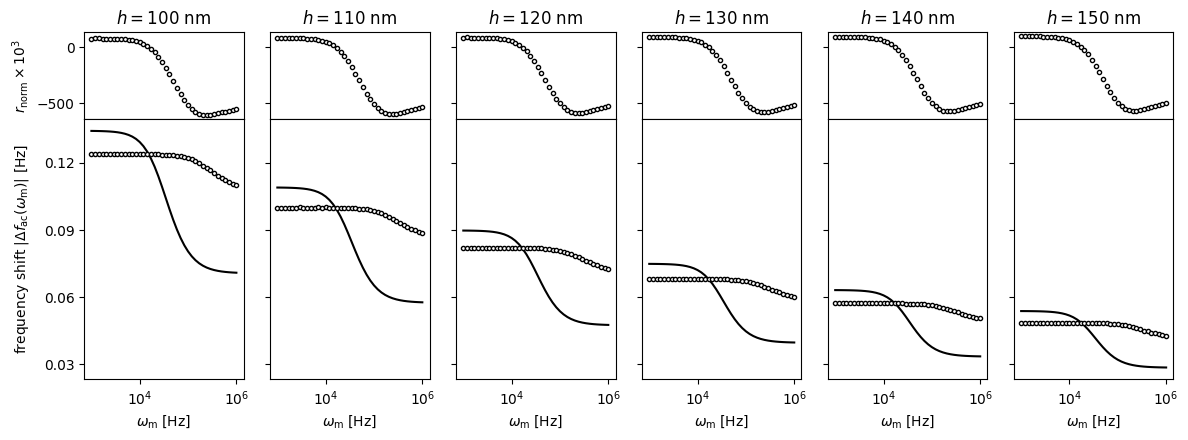

In [262]:
dfam_calc = fitfunc_trial(x, 5, 1e-5, 1e20)
figs['03'] = compareme(h, omega_m__numpy, dfam2, dfam_calc)

We will need to flatten the array for curve fitting. \
Use the fact that the "data", `dfam2`, is the shape we want. 

In [189]:
dfam_calc.shape

(6, 40)

In [190]:
dfam_calc.flatten().shape

(240,)

In [191]:
dfam_calc.flatten().reshape(dfam2.shape).shape

(6, 40)

Define a new fit function that returns flattened data.

In [234]:
def fitfunc(x, epsilon, sigma, rho):
    
    cantilever = CantileverModel(
        f_c=ureg.Quantity(62, "kHz"),
        k_c=ureg.Quantity(2.8, "N/m"),
        V_ts=ureg.Quantity(1, "V"),
        R=ureg.Quantity(60, "nm"),
        angle=ureg.Quantity(20, "degree"),
        L=ureg.Quantity(1000, "nm"),
    )

    sample3 = SampleModel3(
        cantilever=cantilever,
        epsilon_s=ureg.Quantity(complex(epsilon, 0), ""),
        sigma=ureg.Quantity(sigma, "S/m"),
        rho=ureg.Quantity(rho, "1/m^3"),
        z_r=ureg.Quantity(1, "nm"),
    )

    obj = twodimCobjectExperimental(sample3, device)
    obj.addsphere(ureg.Quantity(100,'nm'), 21, 24)  # hardwire h0 = 100 nm
    obj.set_alpha(1.0e-6)
    obj.set_integration_points(21 * 15)
    _, dfam_calc = compute_blds_am(obj, dh__torch, omega_m__torch, omega_am__torch)
    
    return dfam_calc.flatten()

In [235]:
dfam_calc = fitfunc(x.flatten(), 3, 5e-6, 1e21)

Plot of the calculated data. \
Note the use of the `reshape` function to turn the calculated data back into an array.

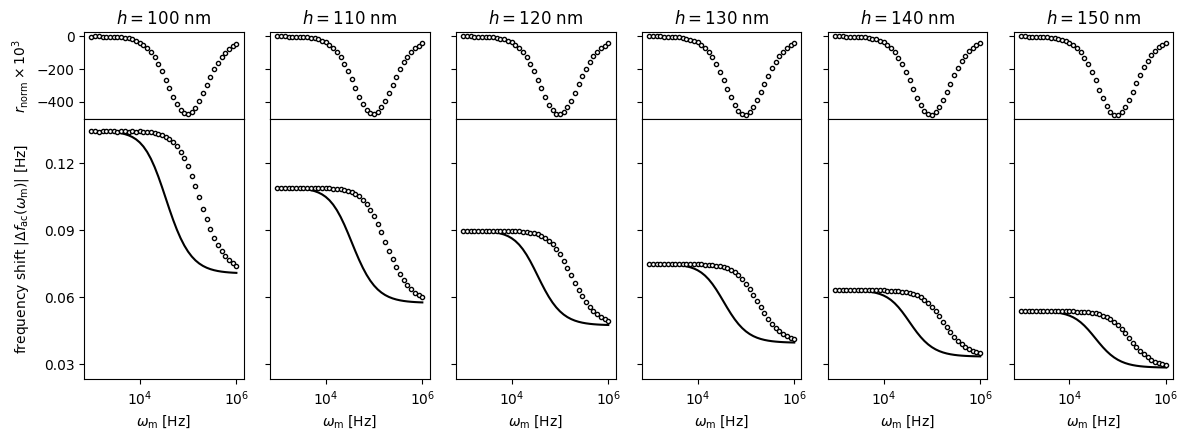

In [236]:
_ = compareme(h, omega_m__numpy, dfam2, dfam_calc.reshape(dfam2.shape))

Set up the parameters.

In [237]:
model = Model(fitfunc)

In [238]:
pars = Parameters()

pars.add('epsilon', value=5.0, min=1.0, max=200.0, vary=True)
pars.add('sigma', value=1e-5, min=1e-1, max=1e-10, vary=True)
pars.add('rho', value=1e20, min=1e16, max=1e24, vary=True)

See the fit in `2025-07-10--jam99--20240222-rerun-ringdown-NiOx-U551--Study-1`. \
Define a callback function to printout how the fit is going.

In [250]:
def my_callback(params, iter, resid, *args, **kws):
    cp = params.valuesdict() 
    ssr = (resid**2).sum()
    message = ' '.join((
         f"iteration {iter:03d}:",
         f" SSR = {ssr:.3e},", 
         f" epsilon = {cp.get('epsilon'):.2e},",
         f" sigma = {cp.get('sigma'):.2e}",
         f" rho = {cp.get('rho'):.2e}"
    ))
    print(message) 

Ready, set, fit. \
I tried the defalt method, because it returns error bars for the best-fit parameters, but the fit was awful.
So instead use `method='Nelder-Mead'`, which converges properly.

In [268]:
result = model.fit(dfam2.flatten(), 
    params=pars,
    x=x.flatten(),
    method='Nelder-Mead',
    iter_cb=my_callback)

iteration 001:  SSR = 8.805e-02,  epsilon = 5.00e+00,  sigma = 1.00e-05  rho = 1.00e+20
iteration 002:  SSR = 6.006e-02,  epsilon = 3.40e+00,  sigma = 1.00e-05  rho = 1.00e+20
iteration 003:  SSR = 1.148e-01,  epsilon = 5.00e+00,  sigma = 8.27e-05  rho = 1.00e+20
iteration 004:  SSR = 1.671e-01,  epsilon = 5.00e+00,  sigma = 1.00e-05  rho = 8.28e+20
iteration 005:  SSR = 2.784e-01,  epsilon = 3.89e+00,  sigma = 2.51e-05  rho = 2.38e+21
iteration 006:  SSR = 4.851e-02,  epsilon = 4.71e+00,  sigma = 1.25e-06  rho = 8.81e+19
iteration 007:  SSR = 9.371e-02,  epsilon = 3.72e+00,  sigma = 1.98e-04  rho = 8.56e+18
iteration 008:  SSR = 9.548e-02,  epsilon = 4.02e+00,  sigma = 6.84e-05  rho = 1.04e+17
iteration 009:  SSR = 9.501e-02,  epsilon = 4.02e+00,  sigma = 4.58e-06  rho = 1.04e+17
iteration 010:  SSR = 7.666e-02,  epsilon = 4.85e+00,  sigma = 4.58e-06  rho = 1.04e+17
iteration 011:  SSR = 7.712e-02,  epsilon = 4.85e+00,  sigma = 1.59e-05  rho = 1.04e+17
iteration 012:  SSR = 9.580e-02,

iteration 095:  SSR = 1.028e-06,  epsilon = 3.01e+00,  sigma = 9.94e-07  rho = 9.98e+20
iteration 096:  SSR = 1.968e-06,  epsilon = 3.00e+00,  sigma = 1.01e-06  rho = 1.00e+21
iteration 097:  SSR = 8.773e-06,  epsilon = 3.02e+00,  sigma = 9.88e-07  rho = 9.98e+20
iteration 098:  SSR = 1.270e-06,  epsilon = 3.00e+00,  sigma = 1.01e-06  rho = 9.96e+20
iteration 099:  SSR = 1.608e-06,  epsilon = 2.99e+00,  sigma = 1.00e-06  rho = 1.01e+21
iteration 100:  SSR = 1.105e-06,  epsilon = 3.00e+00,  sigma = 9.97e-07  rho = 9.99e+20
iteration 101:  SSR = 3.923e-06,  epsilon = 3.00e+00,  sigma = 9.95e-07  rho = 9.85e+20
iteration 102:  SSR = 5.868e-07,  epsilon = 3.00e+00,  sigma = 1.00e-06  rho = 1.00e+21
iteration 103:  SSR = 2.365e-06,  epsilon = 3.00e+00,  sigma = 9.88e-07  rho = 1.00e+21
iteration 104:  SSR = 4.693e-07,  epsilon = 3.00e+00,  sigma = 1.00e-06  rho = 9.98e+20
iteration 105:  SSR = 9.943e-07,  epsilon = 3.00e+00,  sigma = 1.00e-06  rho = 1.00e+21
iteration 106:  SSR = 1.977e-06,

It takes 124 iterations to converge, about 2 minutes. \
Here is the fit result.

In [272]:
result

We get the expected values, and the fit only took a couple of minutes. \
Let's plot the fit results.

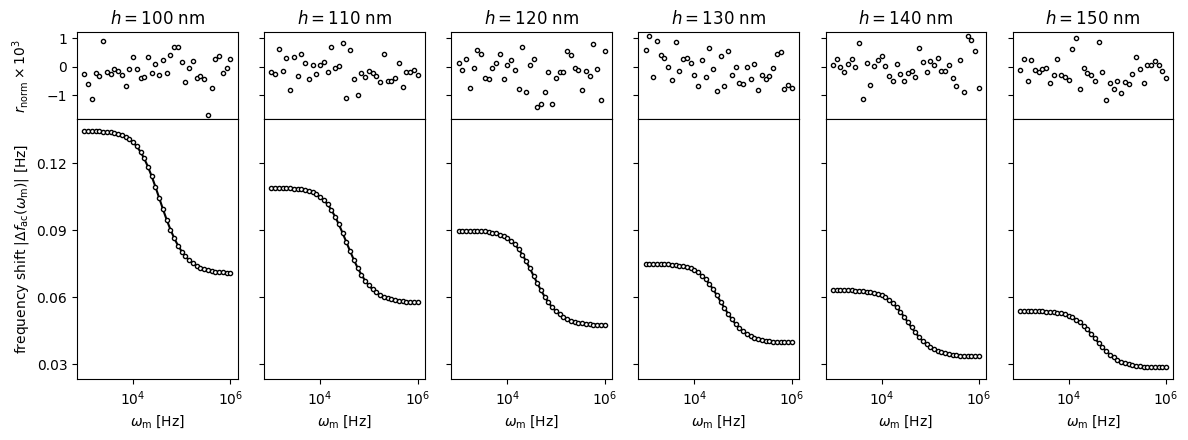

In [270]:
dfam_calc_best = fitfunc(
    x.flatten(),
    result.params['epsilon'].value, 
    result.params['sigma'].value,
    result.params['rho'].value)

figs['04'] = compareme(h, omega_m__numpy, dfam2, dfam_calc_best.reshape(dfam2.shape))

# Next steps

1. Move the above code into a python file. 
2. Code up GPU computations of friction and frequency shift for Type I and Type II samples.
3. Unit test the $K_n$ integral calculations for Type I, II, and III samples against CPU code.  See Studies 63 and 64.
4. Fit spectra.

There is a GPU-accelerated integration function, `torchquad` ([github](https://github.com/esa/torchquad)), but "torchquad's GPU support is tested only on NVIDIA cards with CUDA".  Continue with brute-force integration.

::: {.content-hidden when-format="html"}

# Save the figures

In [264]:
if 1:
    for num in figs.keys():
        figname = THIS + "Fig-" + num
        figs[num].savefig(figname + '.png', dpi=300)
        figs[num].savefig(figname + '.pdf')

# Formatting notes

The header at the top of this file is for creating a nicely-formatted `.html` document using the program `quarto` ([link](https://quarto.org/)).  To create nicely-formated `.html`versions of this notebook, run `quarto` from the command line as follows

    quarto render dissipation-theory--Study-70.ipynb && open dissipation-theory--Study-70.html
    
:::